# 1 - Imports + Preparation

In [1]:
import torch
import numpy as np
import spyrit.misc.walsh_hadamard as wh

from matplotlib import pyplot as plt

from spyrit.learning.model_Had_DCAN import *
from spyrit.misc.disp import torch2numpy, imagesc, plot
# from spyrit.misc.statistics import Cov2Var
# from spyrit.learning.model_Had_DCAN import Cov2Var
from spyrit.learning.nets import *
from spyrit.misc.metrics import psnr_

# from spas import read_metadata, reconstruction_hadamard
# from spas import ReconstructionParameters, setup_reconstruction, load_noise, reconstruct
# from spas.noise import noiseClass
# from spas.visualization import *
#from siemens_star_analysis import *


In [2]:
plt.rcParams['text.usetex'] = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Torch device: {device}')

Torch device: cuda:0


In [3]:
#%% Spectral binning (and checking a few things)
def subsample(spectral_data, CR):
    # If only one wavelength is considered
    if spectral_data.ndim == 1:
        torch_img = np.zeros((2*CR))
        
        pos = spectral_data[0::2][:CR]
        neg = spectral_data[1::2][:CR]
        
        torch_img[0::2] = pos
        torch_img[1::2] = neg
    
    # If spectral_data contains  all wavelengths
    if spectral_data.ndim == 2:
        
        torch_img = np.zeros((2*CR, spectral_data.shape[1]))
        
        pos = spectral_data[0::2][:CR,:]
        neg = spectral_data[1::2][:CR,:]
        
        torch_img[0::2,:] = pos
        torch_img[1::2,:] = neg
    
    return torch_img


def meas2img_from_ind(meas, ind, N):
    """Return image from measurement vector

    Args:
        meas (ndarray): Measurement vector. Must be 1-D.
        ind (ndarray):  Pattern indices. Must be 1-D.
        N (int):        Returned image will be N x N

    Returns:
        Img (ndarray): Measurement image. 2-D array
    """
    y = np.pad(meas, (0, N**2-len(meas)))
    Perm = permutation_from_ind(ind+1)
    Img = (Perm @ y).reshape((N, N))
    return Img

def completion(meas, M, Perm, Cov, Mean):
    
    nx, ny = Mean.shape
    
    # reorder measurements and statistics
    y     = Perm @ (meas.ravel())
    mu    = Perm @ (Mean.ravel())
    Sigma = Perm @ Cov @ Perm.T
    
    # extract blocks corresponding to acquired and missing measurements 
    mu1 = mu[:M]            # mean of acquired measurements
    mu2 = mu[M:]            # mean of missing measurements
    Sigma1  = Sigma[:M,:M]  # covariance of acquired measurements
    Sigma21 = Sigma[M:,:M]  # covariance of missing measurements

    m = y[:M];
    
    # Bayesian denoised completion
    #y1 = mu1 + W1 @ ( m - mu1)
    y1 = m
    #y2 = mu2 + Sigma21 @ np.linalg.lstsq(Sigma1,(y1 - mu1), rcond=None)[0]
    y2 = Sigma21 @ np.linalg.lstsq(Sigma1, y1, rcond=None)[0]
    #y2 = Sigma21 @ np.linalg.inv(Sigma1) @ y1
    y[:M] = y1
    y[M:] = y2
    
    # reorder output
    y = Perm.T @ y
    y = np.reshape(y,(nx, ny))
    
    return y

def unsplit(raw):
    had = raw[0::2] - raw[1::2]
    return had



# 2 - $CR = 1/2$
## 2.1 - Parameters and Neural Network

In [4]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 2048;

# Intensity distribution
N0 = 10
sig = 0

In [5]:
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

In [6]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [7]:
n_iter = 4;
net_arch = 0;
model_root = '../../models/SPIE_europe_2022/EM/'
title = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi = DConvNet();
denoi = sn_dp_iteratif_2(CR, img_size, Cov,H, denoi, n_iter = n_iter)
model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, denoi=denoi);
model.recon.completion_layer.weight.requires_grad = False;
model.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model = model.to(device);
load_net(title, model);
model.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/SPIE_europe_2022/EM/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# 2.2 - Usaf zoom x12

### 2.2.1 - Loading data and visualising

In [8]:
f = np.load('./data/usaf_x12/zoom_x12_usaf_group5_had_reco.npz')
raw = np.load('./data/usaf_x12/zoom_x12_usaf_group5_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


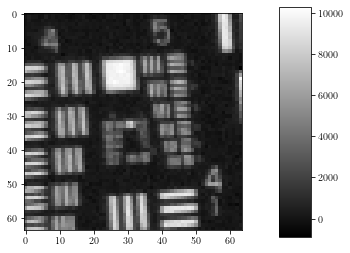

In [9]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

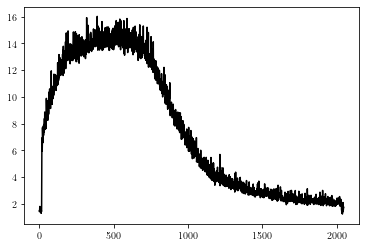

In [10]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 2.2.2 - Reconstructing hyperspectral cube

In [11]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [12]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x12_em_net_{}".format(CR), cube_em_net);

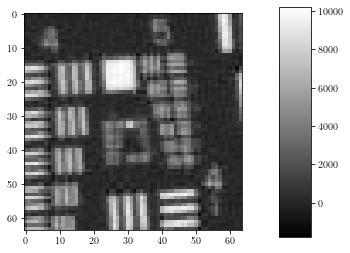

In [13]:
imagesc(np.sum(cube_pinv, axis = 0))

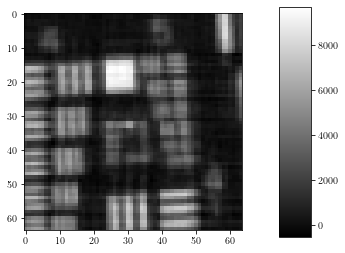

In [14]:
imagesc(np.sum(cube_mmse, axis = 0))

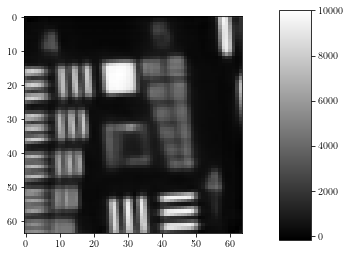

In [15]:
imagesc(np.sum(cube_em_net, axis = 0))

# 2.3 - usaf x2

### 2.3.1 - Loading data and visualising

In [16]:
f = np.load('./data/usaf_x2/zoom_x2_usaf_group2_had_reco.npz')
raw = np.load('./data/usaf_x2/zoom_x2_usaf_group2_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


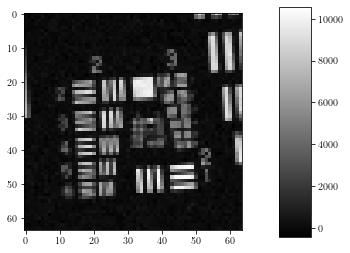

In [17]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

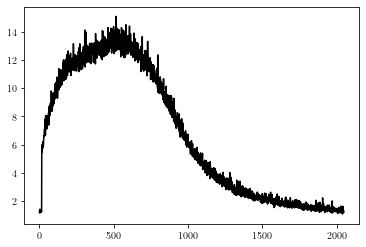

In [18]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 2.3.2 - Reconstructing hyperspectral cube

In [19]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [20]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x2_em_net_{}".format(CR), cube_em_net);

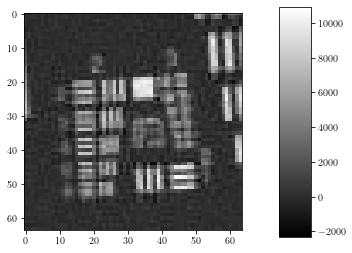

In [21]:
imagesc(np.sum(cube_pinv, axis = 0))

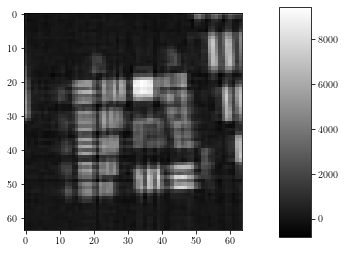

In [22]:
imagesc(np.sum(cube_mmse, axis = 0))

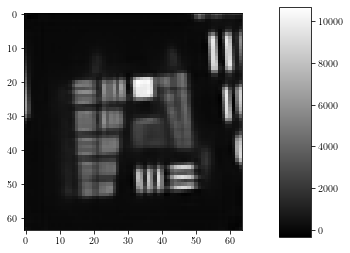

In [23]:
imagesc(np.sum(cube_em_net, axis = 0))

# 2.4 - Star Sector zoom x2

### 2.4.1 - Loading data and visualising

In [24]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x2/zoom_x2_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


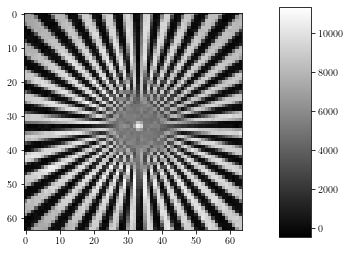

In [25]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

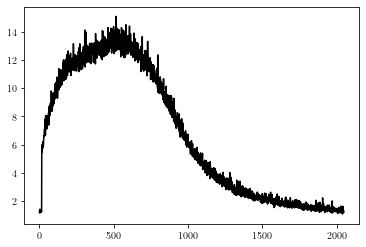

In [26]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 2.4.2 - Reconstructing hyperspectral cube

In [27]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [28]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x2_em_net_{}".format(CR), cube_em_net);

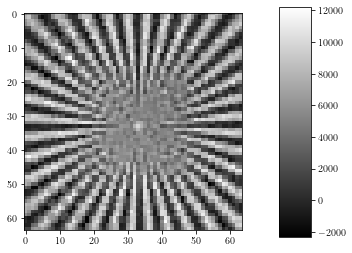

In [29]:
imagesc(np.sum(cube_pinv, axis = 0))

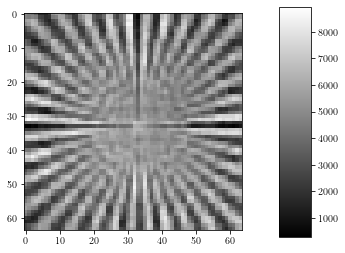

In [30]:
imagesc(np.sum(cube_mmse, axis = 0))

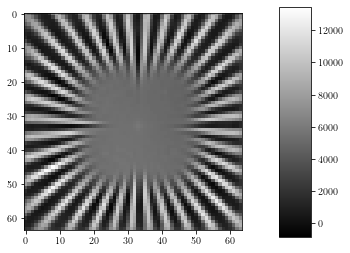

In [31]:
imagesc(np.sum(cube_em_net, axis = 0))

# 2.5 - Star Sector zoom x12

### 2.5.1 - Loading data and visualising

In [32]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x12/zoom_x12_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']



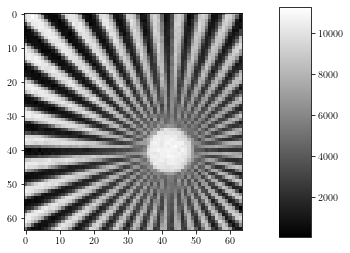

In [33]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

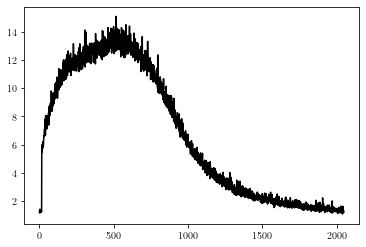

In [34]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 2.5.2 - Reconstructing hyperspectral cube

In [35]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [36]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x12_em_net_{}".format(CR), cube_em_net);

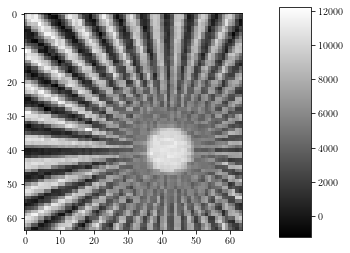

In [37]:
imagesc(np.sum(cube_pinv, axis = 0))

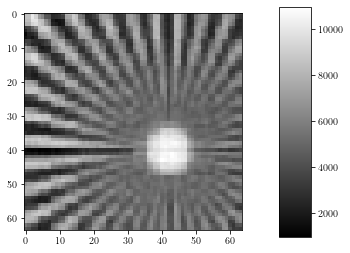

In [38]:
imagesc(np.sum(cube_mmse, axis = 0))

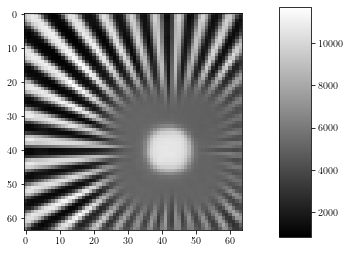

In [39]:
imagesc(np.sum(cube_em_net, axis = 0))

# 3 - $CR = 1/4$
## 3.1 - Parameters and Neural Network

In [40]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 1024;

# Intensity distribution
N0 = 10
sig = 0

In [41]:
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

In [42]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [43]:
n_iter = 4;
net_arch = 0;
model_root = '../../models/SPIE_europe_2022/EM/'
title = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi = DConvNet();
denoi = sn_dp_iteratif_2(CR, img_size, Cov,H, denoi, n_iter = n_iter)
model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, denoi=denoi);
model.recon.completion_layer.weight.requires_grad = False;
model.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model = model.to(device);
load_net(title, model);
model.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/SPIE_europe_2022/EM/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# 3.2 - Usaf x12

### 3.2.1 - Loading data and visualising

In [44]:
f = np.load('./data/usaf_x12/zoom_x12_usaf_group5_had_reco.npz')
raw = np.load('./data/usaf_x12/zoom_x12_usaf_group5_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']



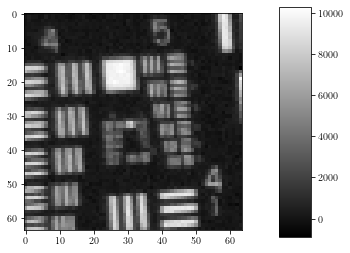

In [45]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

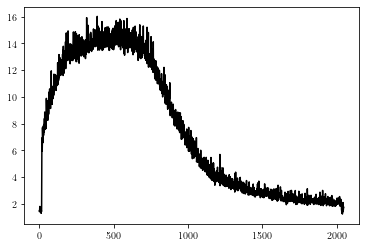

In [46]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 3.2.2 - Reconstructing hyperspectral cube

In [47]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [48]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x12_em_net_{}".format(CR), cube_em_net);

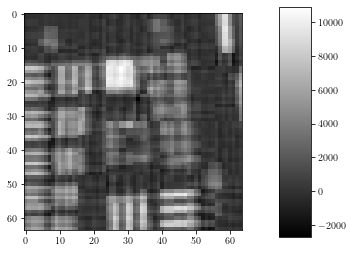

In [49]:
imagesc(np.sum(cube_pinv, axis = 0))

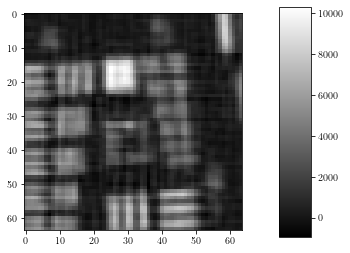

In [50]:
imagesc(np.sum(cube_mmse, axis = 0))

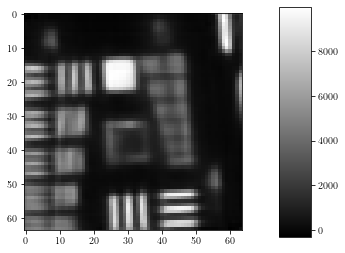

In [51]:
imagesc(np.sum(cube_em_net, axis = 0))

# 3.3 - Usaf x2

### 3.3.1 - Loading data and visualising

In [52]:
f = np.load('./data/usaf_x2/zoom_x2_usaf_group2_had_reco.npz')
raw = np.load('./data/usaf_x2/zoom_x2_usaf_group2_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']

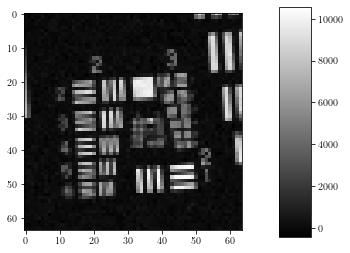

In [53]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

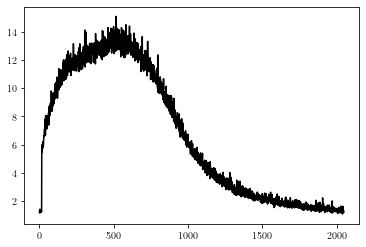

In [54]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 3.3.2 - Reconstructing hyperspectral cube

In [55]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [56]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x2_em_net_{}".format(CR), cube_em_net);

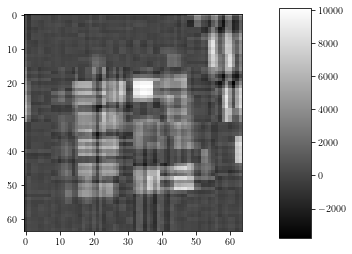

In [57]:
imagesc(np.sum(cube_pinv, axis = 0))

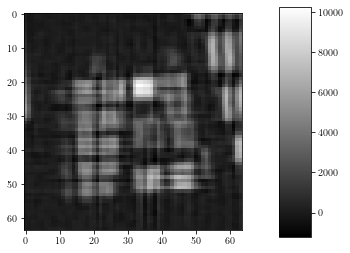

In [58]:
imagesc(np.sum(cube_mmse, axis = 0))

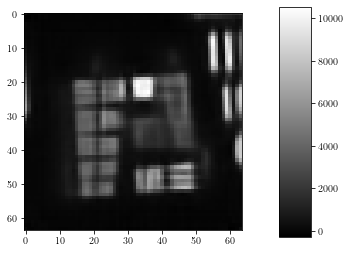

In [59]:
imagesc(np.sum(cube_em_net, axis = 0))

# 3.4 - Star Sector zoom x2

### 3.4.1 - Loading data and visualising

In [60]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x2/zoom_x2_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']

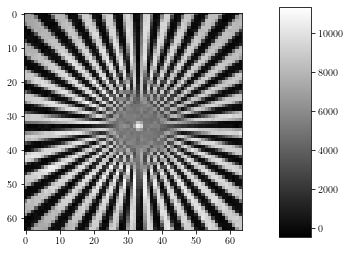

In [61]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

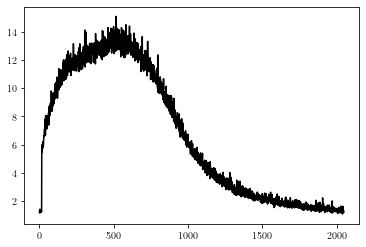

In [62]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 3.4.2 - Reconstructing hyperspectral cube

In [63]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [64]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x2_em_net_{}".format(CR), cube_em_net);

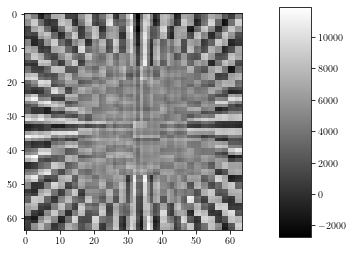

In [65]:
imagesc(np.sum(cube_pinv, axis = 0))

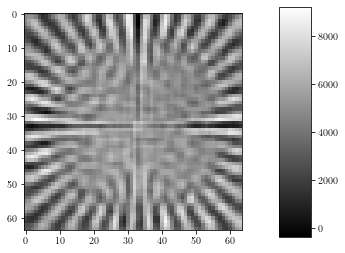

In [66]:
imagesc(np.sum(cube_mmse, axis = 0))

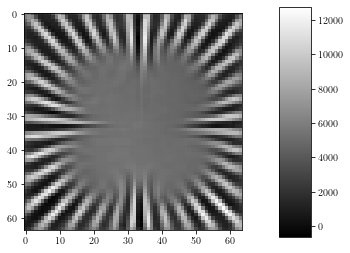

In [67]:
imagesc(np.sum(cube_em_net, axis = 0))

# 3.5 - Star Sector zoom x12

### 3.5.1 - Loading data and visualising

In [68]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x12/zoom_x12_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']



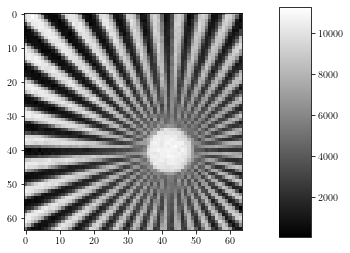

In [69]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

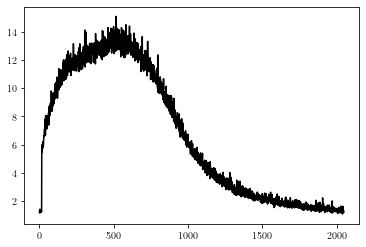

In [70]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 3.5.2 - Reconstructing hyperspectral cube

In [71]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [72]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x12_em_net_{}".format(CR), cube_em_net);

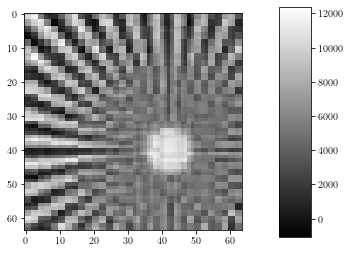

In [73]:
imagesc(np.sum(cube_pinv, axis = 0))

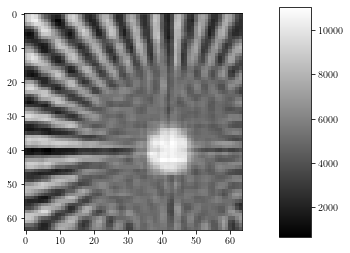

In [74]:
imagesc(np.sum(cube_mmse, axis = 0))

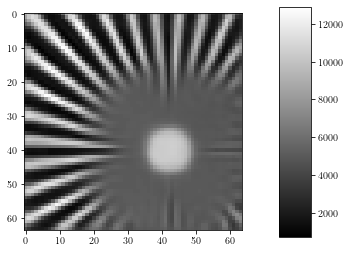

In [75]:
imagesc(np.sum(cube_em_net, axis = 0))

# 4 - $CR = 1/8$
## 4.1 - Parameters and Neural Network

In [76]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 512;

# Intensity distribution
N0 = 10
sig = 0

In [77]:
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

In [78]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [79]:
n_iter = 4;
net_arch = 0;
model_root = '../../models/SPIE_europe_2022/EM/'
title = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi = DConvNet();
denoi = sn_dp_iteratif_2(CR, img_size, Cov,H, denoi, n_iter = n_iter)
model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, denoi=denoi);
model.recon.completion_layer.weight.requires_grad = False;
model.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model = model.to(device);
load_net(title, model);
model.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/SPIE_europe_2022/EM/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


# 4.2 - usaf x12

### 4.2.1 - Loading data and visualising

In [80]:
f = np.load('./data/usaf_x12/zoom_x12_usaf_group5_had_reco.npz')
raw = np.load('./data/usaf_x12/zoom_x12_usaf_group5_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


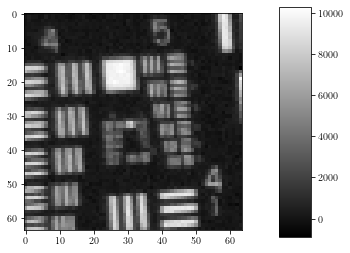

In [81]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

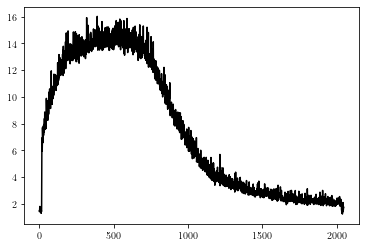

In [82]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.2.2 - Reconstructing hyperspectral cube

In [83]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [84]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x12_em_net_{}".format(CR), cube_em_net);

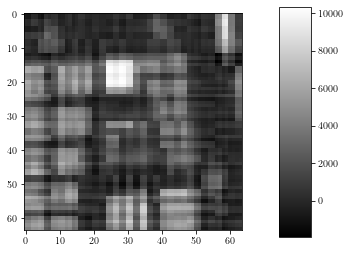

In [85]:
imagesc(np.sum(cube_pinv, axis = 0))

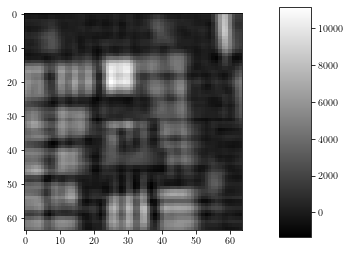

In [86]:
imagesc(np.sum(cube_mmse, axis = 0))

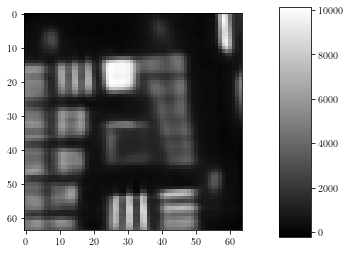

In [87]:
imagesc(np.sum(cube_em_net, axis = 0))

# 4.3 - usaf x2

### 4.3.1 - Loading data and visualising

In [88]:
f = np.load('./data/usaf_x2/zoom_x2_usaf_group2_had_reco.npz')
raw = np.load('./data/usaf_x2/zoom_x2_usaf_group2_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


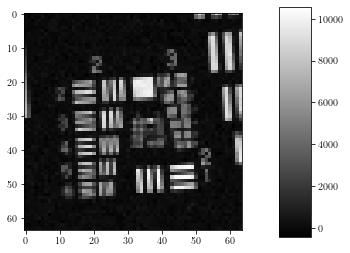

In [89]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

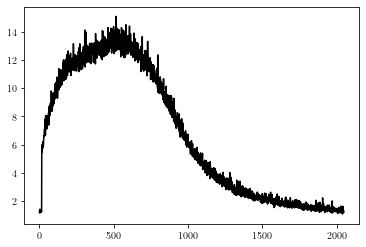

In [90]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.3.2 - Reconstructing hyperspectral cube

In [91]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [92]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/usaf_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/usaf_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/usaf_x2_em_net_{}".format(CR), cube_em_net);

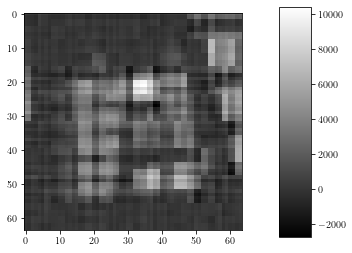

In [93]:
imagesc(np.sum(cube_pinv, axis = 0))

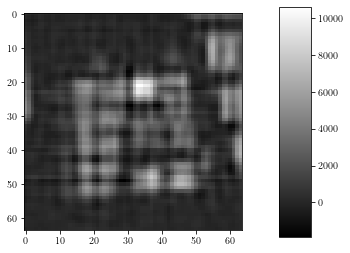

In [94]:
imagesc(np.sum(cube_mmse, axis = 0))

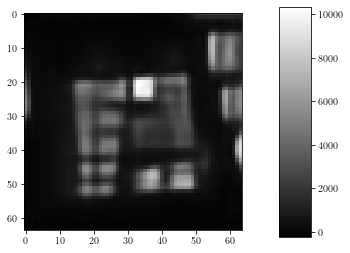

In [95]:
imagesc(np.sum(cube_em_net, axis = 0))

# 4.4 - Star Sector zoom x2

### 4.4.1 - Loading data and visualising

In [96]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x2/zoom_x2_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']

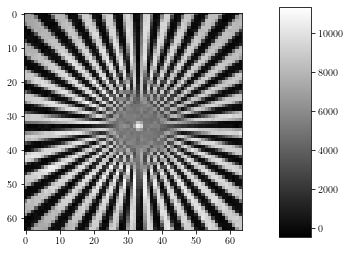

In [97]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

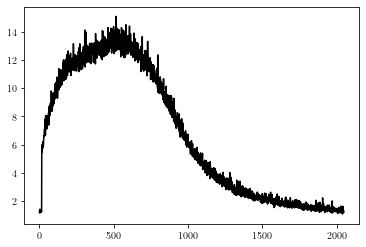

In [98]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.4.2 - Reconstructing hyperspectral cube

In [99]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [100]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x2_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x2_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x2_em_net_{}".format(CR), cube_em_net);

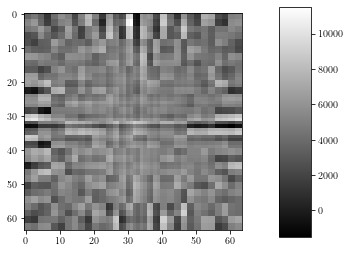

In [101]:
imagesc(np.sum(cube_pinv, axis = 0))

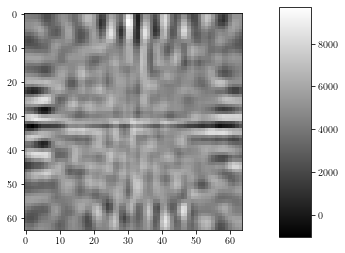

In [102]:
imagesc(np.sum(cube_mmse, axis = 0))

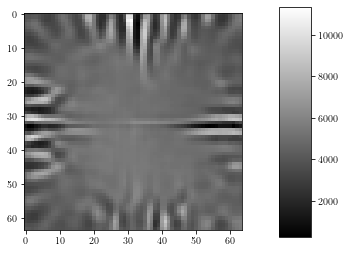

In [103]:
imagesc(np.sum(cube_em_net, axis = 0))

# 4.5 - Star Sector zoom x12

### 4.5.1 - Loading data and visualising

In [104]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x12/zoom_x12_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


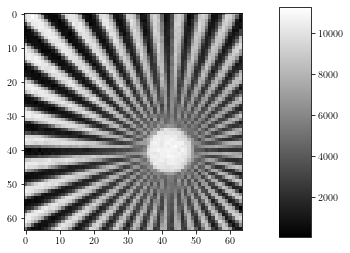

In [105]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

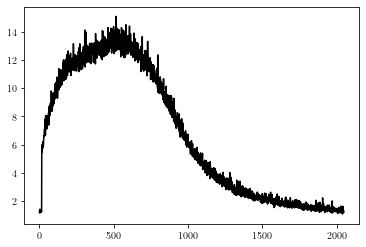

In [106]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.5.2 - Reconstructing hyperspectral cube

In [107]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [108]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result;
np.save("./results_OE/star_sector_x12_pinv_{}".format(CR), cube_pinv);
np.save("./results_OE/star_sector_x12_mmse_{}".format(CR), cube_mmse);
np.save("./results_OE/star_sector_x12_em_net_{}".format(CR), cube_em_net);

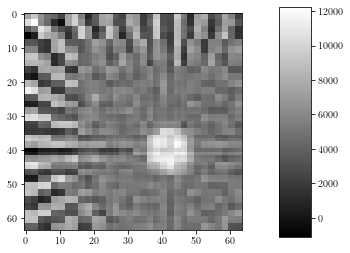

In [109]:
imagesc(np.sum(cube_pinv, axis = 0))

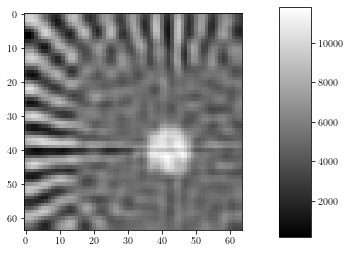

In [110]:
imagesc(np.sum(cube_mmse, axis = 0))

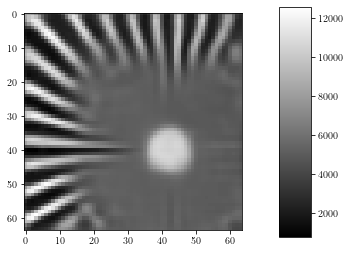

In [111]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5 - $CR = 1$
## 5.1 - Parameters and Neural Network

In [112]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 4096;

# Intensity distribution
N0 = 10
sig = 0

In [113]:
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

In [114]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

# 5.2 - usaf x12

### 4.2.1 - Loading data and visualising

In [115]:
f = np.load('./data/usaf_x12/zoom_x12_usaf_group5_had_reco.npz')
raw = np.load('./data/usaf_x12/zoom_x12_usaf_group5_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


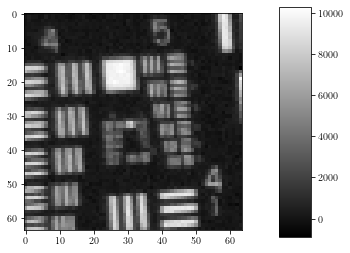

In [116]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

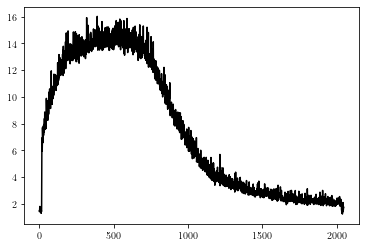

In [117]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.2.2 - Reconstructing hyperspectral cube

In [118]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [119]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/usaf_x12_pinv_{}".format(CR), cube_pinv);

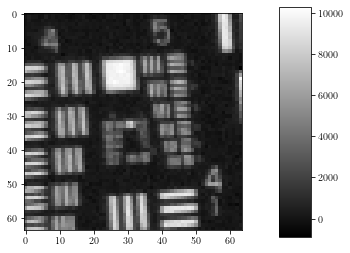

In [120]:
imagesc(np.sum(cube_pinv, axis = 0))

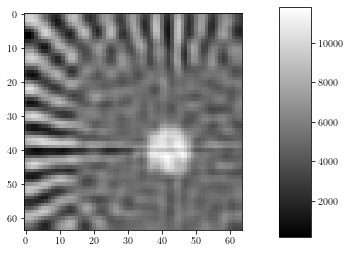

In [121]:
imagesc(np.sum(cube_mmse, axis = 0))

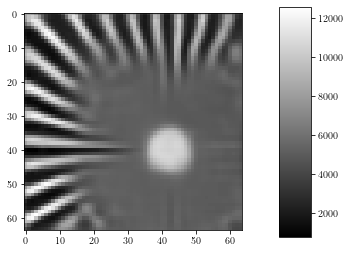

In [122]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5.3 - usaf x2

### 4.3.1 - Loading data and visualising

In [123]:
f = np.load('./data/usaf_x2/zoom_x2_usaf_group2_had_reco.npz')
raw = np.load('./data/usaf_x2/zoom_x2_usaf_group2_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


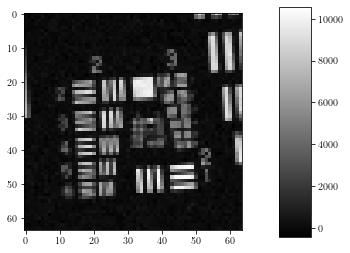

In [124]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

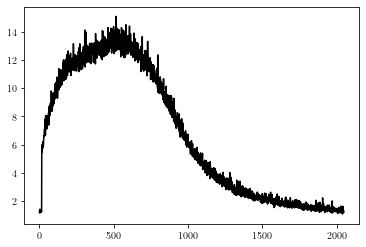

In [125]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.3.2 - Reconstructing hyperspectral cube

In [126]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [127]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/usaf_x2_pinv_{}".format(CR), cube_pinv);

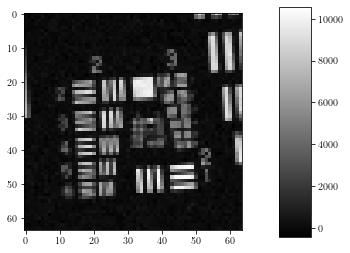

In [128]:
imagesc(np.sum(cube_pinv, axis = 0))

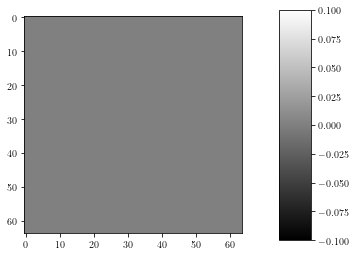

In [129]:
imagesc(np.sum(cube_mmse, axis = 0))

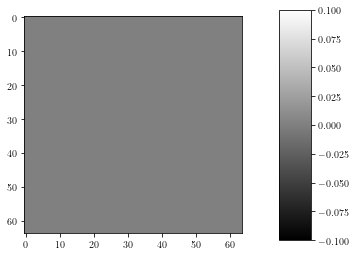

In [130]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5.4 - Star Sector zoom x2

### 4.4.1 - Loading data and visualising

In [131]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x2/zoom_x2_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']

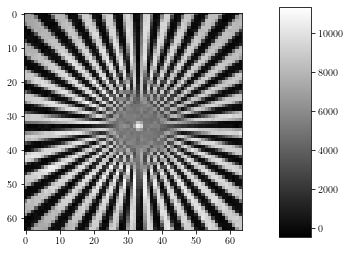

In [132]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

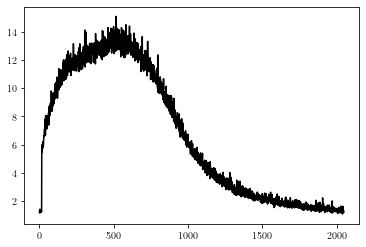

In [133]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.4.2 - Reconstructing hyperspectral cube

In [134]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [135]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/star_sector_x2_pinv_{}".format(CR), cube_pinv);

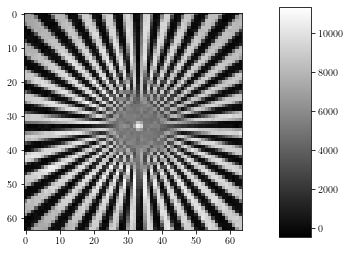

In [136]:
imagesc(np.sum(cube_pinv, axis = 0))

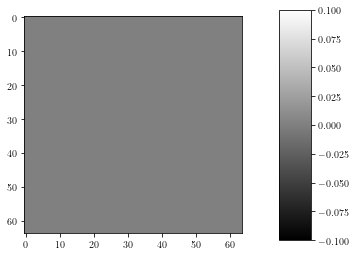

In [137]:
imagesc(np.sum(cube_mmse, axis = 0))

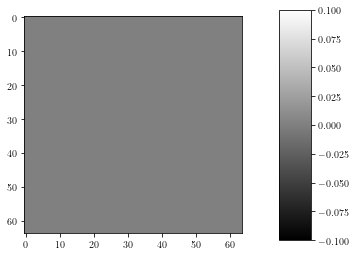

In [138]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5.5 - Star Sector zoom x12

### 4.5.1 - Loading data and visualising

In [139]:
# f = np.load('./data/tomato_slice_x6/tomato_slice_2_zoomx6_had_reco.npz')
raw = np.load('./data/star_sector_x12/zoom_x12_starsector_spectraldata.npz')

# spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


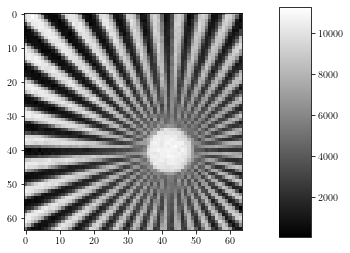

In [140]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

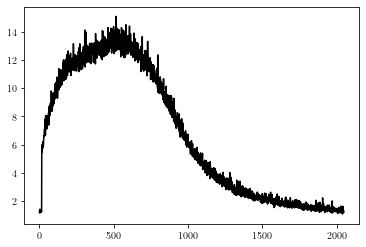

In [141]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.5.2 - Reconstructing hyperspectral cube

In [142]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [143]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/star_sector_x12_pinv_{}".format(CR), cube_pinv);

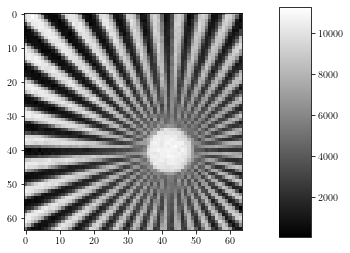

In [144]:
imagesc(np.sum(cube_pinv, axis = 0))

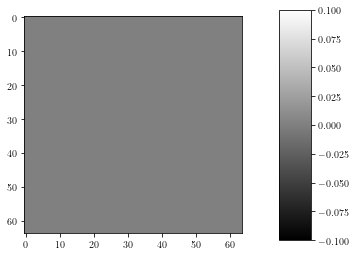

In [145]:
imagesc(np.sum(cube_mmse, axis = 0))

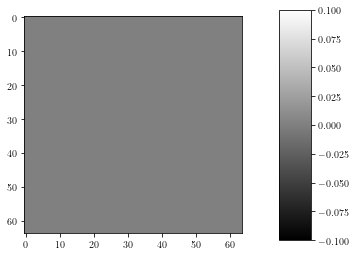

In [146]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5.6 - Tomato slice x12

### 4.5.1 - Loading data and visualising

In [151]:
f = np.load('./data/tomato_slice_x12/tomato_slice_2_zoomx12_had_reco.npz')
raw = np.load('./data/tomato_slice_x12/tomato_slice_2_zoomx12_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']



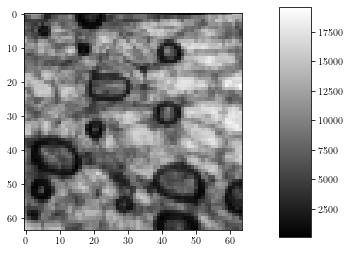

In [152]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

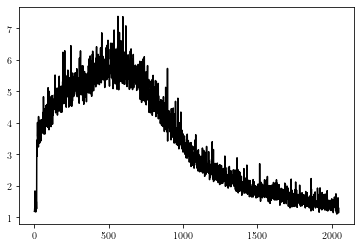

In [153]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.5.2 - Reconstructing hyperspectral cube

In [154]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [155]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/tomato_x12_pinv_{}".format(CR), cube_pinv);

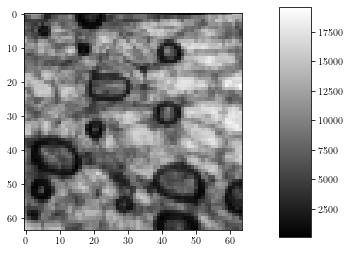

In [156]:
imagesc(np.sum(cube_pinv, axis = 0))

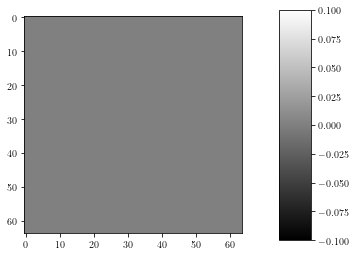

In [157]:
imagesc(np.sum(cube_mmse, axis = 0))

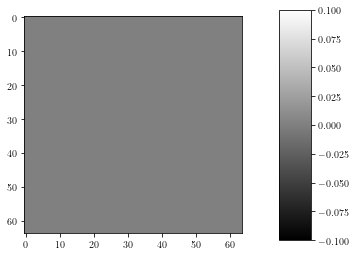

In [158]:
imagesc(np.sum(cube_em_net, axis = 0))

# 5.7 - Tomato slice zoom x2

### 4.5.1 - Loading data and visualising

In [159]:
f = np.load('./data/tomato_slice_x2/tomato_slice_2_zoomx2_had_reco.npz')
raw = np.load('./data/tomato_slice_x2/tomato_slice_2_zoomx2_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


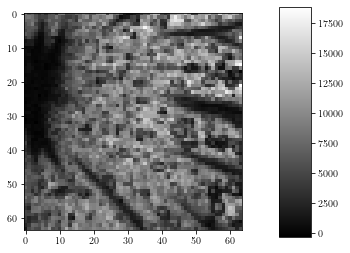

In [160]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

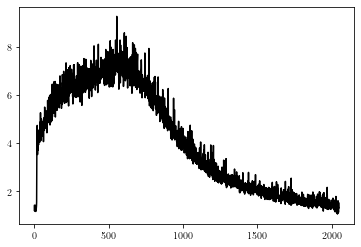

In [161]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 4.5.2 - Reconstructing hyperspectral cube

In [162]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [163]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))
    cube_pinv[index,:,:] = recon_pinv;

np.save("./results_OE/tomato_x2_pinv_{}".format(CR), cube_pinv);

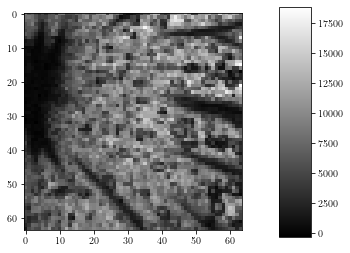

In [164]:
imagesc(np.sum(cube_pinv, axis = 0))

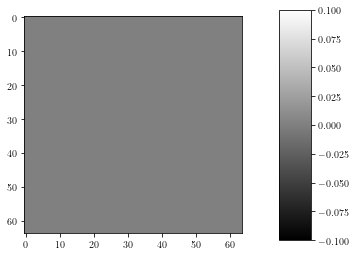

In [165]:
imagesc(np.sum(cube_mmse, axis = 0))

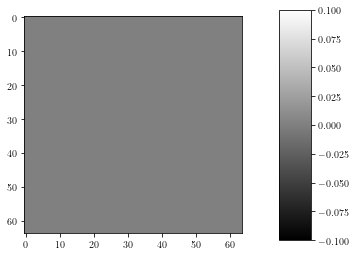

In [166]:
imagesc(np.sum(cube_em_net, axis = 0))

# 6 - Evaluation of time for hyperspectral cube

In [147]:
m_raw_data = raw_data_h[:2*CR,:];

In [148]:
m_raw_data.shape

(8192, 2048)

In [149]:
raw_unsplit = m_raw_data[0::2,:] - m_raw_data[1::2,:];

In [150]:
raw_unsplit.shape

(4096, 2048)